In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("BitcoinHeistData.csv")  

# Check the dataset
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB
None
                              address  year  day  length    weight  count  \
0   111K8kZAEnJg245r2cM6y9zgJGHZtJPy6  2017   11      18  0.008333      1   
1  1123pJv8jzeFQaCV4w644pzQJzVWay2zcA  2016  132      44  0.000244      1   
2  112536im7hy6wtKbpH1qYDWtTyMRAcA2p7  2016  246       0  1.000000      1   
3  1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7  2016  322      72  0.003906      1   
4  1129TSjKtx65E35GiUo4AYVeyo48twbrGX  2016  238     144  0.072848    456   

   looped  neighbors       income            label  
0       0     

# Pre Processing

In [36]:
# Drop unnecessary columns
df.drop(columns=['address', 'year', 'day'], inplace=True)

# Convert label to binary (0 = legitimate, 1 = ransomware)
df['label'] = df['label'].apply(lambda x: 0 if x == 'white' else 1)

#### Data Sampling

In [37]:
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Randomly select 200,000 transactions (includes all ransomware transactions)
df_ransomware = df[df['label'] == 1]  # All ransomware transactions (41,413)
df_legitimate = df[df['label'] == 0].sample(n=158587, random_state=42)  # Sample 158,587 legitimate transactions

# Combine the sampled data
df_sampled = pd.concat([df_ransomware, df_legitimate])

# Step 2: Apply undersampling to further reduce majority class
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # 1:1 balance
X_sampled = df_sampled.drop(columns=['label'])
y_sampled = df_sampled['label']
X_balanced, y_balanced = undersampler.fit_resample(X_sampled, y_sampled)

# Final balanced dataset (≈ 82,826 instances)
df_balanced = pd.concat([pd.DataFrame(X_balanced, columns=X_sampled.columns), pd.DataFrame(y_balanced, columns=['label'])], axis=1)

# Check new class distribution
print(df_balanced['label'].value_counts())

label
0    41413
1    41413
Name: count, dtype: int64


#### Label Encoding

In [38]:
from sklearn.preprocessing import LabelEncoder

# Ensure labels are properly formatted as integers
df_balanced['label'] = df_balanced['label'].astype(int)

# Check unique values
print("Unique label values:", df_balanced['label'].unique())

Unique label values: [0 1]


#### Anamoly Detection

In [39]:
from scipy.stats import zscore

# Compute Z-score for numerical features
z_scores = df_balanced.drop(columns=['label']).apply(zscore)

# Set threshold for outlier detection (|Z| > 3)
df_filtered = df_balanced[(z_scores < 3).all(axis=1)]

# Check dataset size after removing outliers
print("Dataset size after outlier removal:", df_filtered.shape)


Dataset size after outlier removal: (78934, 7)


#### Data Standardization

In [40]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Apply standardization to numerical features
numerical_cols = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']
df_filtered[numerical_cols] = scaler.fit_transform(df_filtered[numerical_cols])

# Check dataset statistics
print(df_filtered.describe())


             length        weight         count        looped     neighbors  \
count  7.893400e+04  7.893400e+04  7.893400e+04  7.893400e+04  7.893400e+04   
mean   7.471438e-17 -1.620312e-18  5.815119e-17  3.600693e-18  4.752915e-17   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -6.916573e-01 -7.279752e-01 -4.106473e-01 -2.053160e-01 -5.650175e-01   
25%   -6.916573e-01 -6.752904e-01 -4.106473e-01 -2.053160e-01 -5.650175e-01   
50%   -5.842987e-01 -2.675187e-01 -4.106473e-01 -2.053160e-01  4.430132e-02   
75%    3.103569e-01  6.533943e-01 -3.998358e-01 -2.053160e-01  4.430132e-02   
max    1.884951e+00  1.185764e+01  4.847691e+00  7.559162e+00  2.990092e+01   

             income         label  
count  7.893400e+04  78934.000000  
mean  -7.201386e-18      0.509730  
std    1.000006e+00      0.499908  
min   -1.914097e-01      0.000000  
25%   -1.841896e-01      0.000000  
50%   -1.732558e-01      1.000000  
75%   -1.242249e-01      1.000000  


C:\Users\madhe\AppData\Local\Temp\ipykernel_4032\2912185167.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[numerical_cols] = scaler.fit_transform(df_filtered[numerical_cols])


#### Correlation Analysis

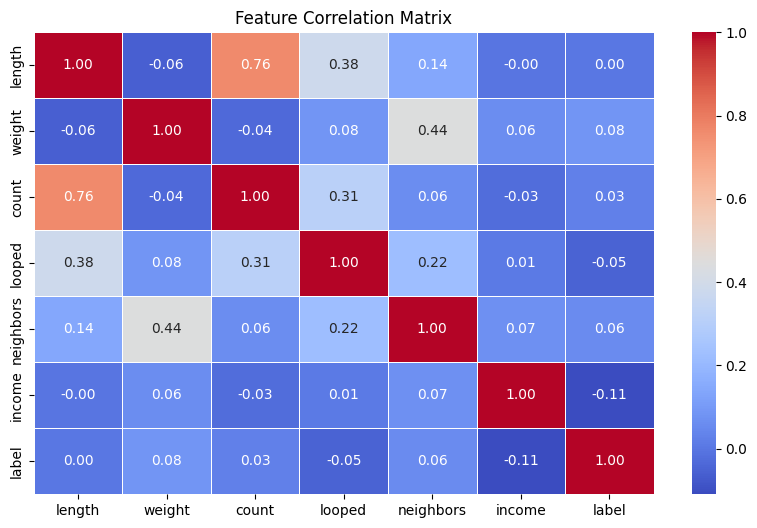

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df_filtered.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# EDA

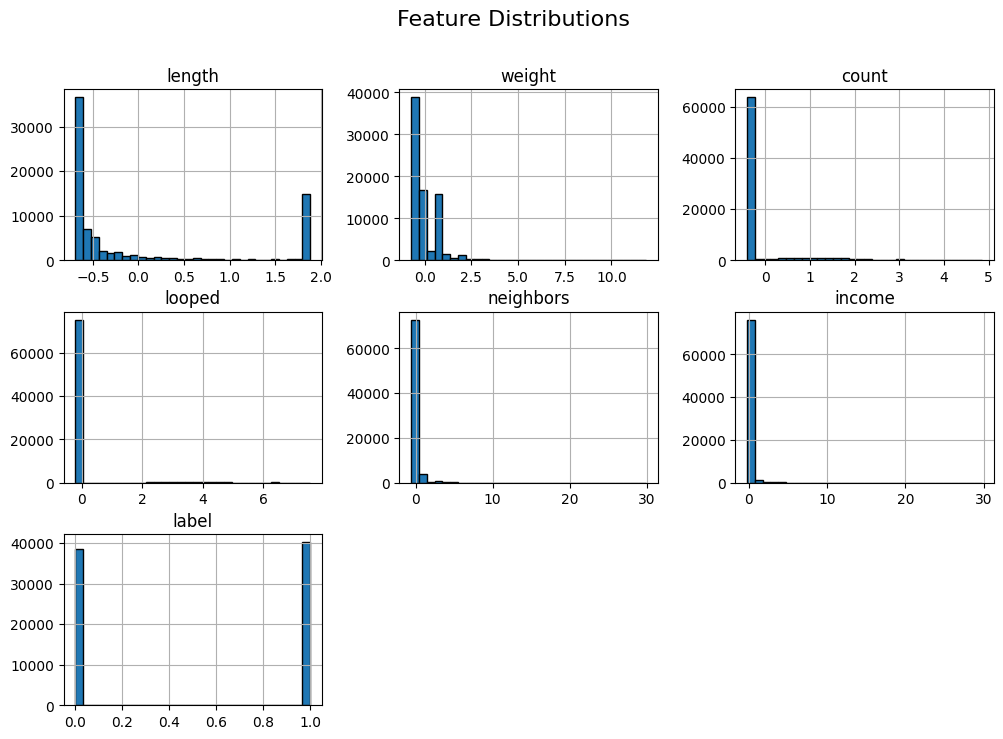

In [42]:
import matplotlib.pyplot as plt

# Plot histograms for each feature
df_filtered.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


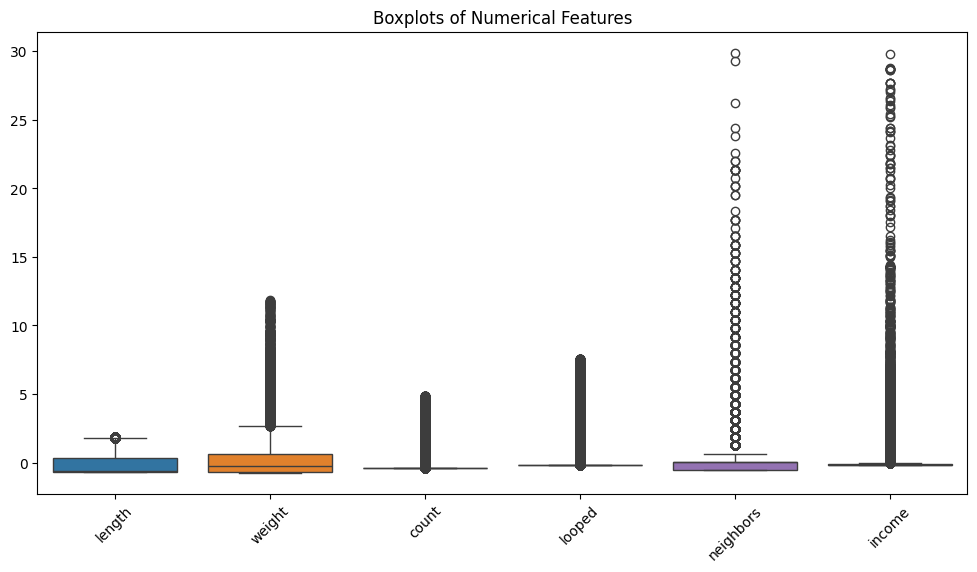

In [43]:
import seaborn as sns

# Plot boxplots for numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered.drop(columns=['label']))
plt.xticks(rotation=45)
plt.title("Boxplots of Numerical Features")
plt.show()


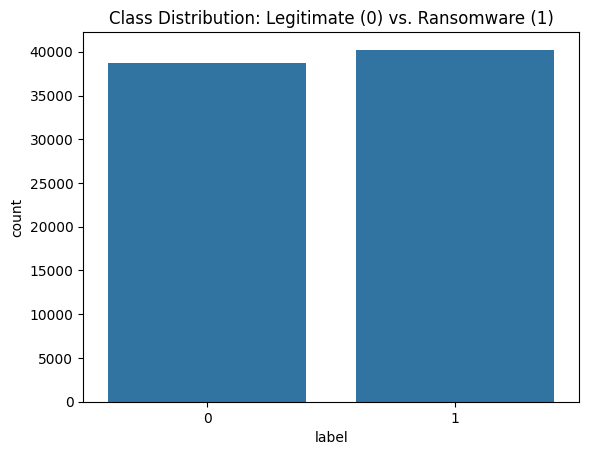

In [44]:
sns.countplot(x=df_filtered['label'])
plt.title("Class Distribution: Legitimate (0) vs. Ransomware (1)")
plt.show()


# training

In [45]:
from sklearn.model_selection import train_test_split

# 66% training, 33% testing (as per the paper)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 52885
Testing samples: 26049


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    "max_iter": [200, 500, 1000]
}

# Random Search
lr = LogisticRegression()
random_search_lr = RandomizedSearchCV(lr, param_grid_lr, n_iter=10, scoring="accuracy", cv=5, random_state=42)
random_search_lr.fit(X_train, y_train)

# Best parameters
print("Best parameters for LR:", random_search_lr.best_params_)


Best parameters for LR: {'max_iter': 500, 'C': 10}


In [47]:
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10]
}

# Random Search
rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_grid_rf, n_iter=10, scoring="accuracy", cv=5, random_state=42)
random_search_rf.fit(X_train, y_train)

# Best parameters
print("Best parameters for RF:", random_search_rf.best_params_)


Best parameters for RF: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}


In [48]:
from xgboost import XGBClassifier

# Define parameter grid
param_grid_xgb = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "gamma": [0, 0.1, 0.3, 0.5]
}

# Random Search
xgb = XGBClassifier(random_state=42)
random_search_xgb = RandomizedSearchCV(xgb, param_grid_xgb, n_iter=10, scoring="accuracy", cv=5, random_state=42)
random_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters for XGBoost:", random_search_xgb.best_params_)


Best parameters for XGBoost: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5}


In [49]:
# Train models with best params
lr_best = LogisticRegression(**random_search_lr.best_params_)
rf_best = RandomForestClassifier(**random_search_rf.best_params_)
xgb_best = XGBClassifier(**random_search_xgb.best_params_)

lr_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)
xgb_best.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_best.predict(X_test)
y_pred_rf = rf_best.predict(X_test)
y_pred_xgb = xgb_best.predict(X_test)


In [50]:
from sklearn.metrics import classification_report

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.62      0.42      0.50     12771
           1       0.58      0.76      0.65     13278

    accuracy                           0.59     26049
   macro avg       0.60      0.59      0.58     26049
weighted avg       0.60      0.59      0.58     26049

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72     12771
           1       0.73      0.77      0.75     13278

    accuracy                           0.74     26049
   macro avg       0.74      0.74      0.74     26049
weighted avg       0.74      0.74      0.74     26049

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     12771
           1       0.76      0.73      0.75     13278

    accuracy                           0.75     26049
   macro avg       0.75      0.75      0.75    

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define a more detailed hyperparameter grid
param_grid_xgb = {
    "n_estimators": [300, 500, 700],  
    "learning_rate": [0.05, 0.1, 0.2],  
    "max_depth": [5, 10, 15],  
    "gamma": [0, 0.1, 0.2],  
    "subsample": [0.8, 1.0],  
    "colsample_bytree": [0.8, 1.0]  
}

# Perform exhaustive Grid Search
xgb = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Train the best model
xgb_best = XGBClassifier(**grid_search_xgb.best_params_)
xgb_best.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_best.predict(X_test)

# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix

print("Optimized XGBoost Performance:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Optimized XGBoost Performance:
[[9806 2965]
 [3524 9754]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     12771
           1       0.77      0.73      0.75     13278

    accuracy                           0.75     26049
   macro avg       0.75      0.75      0.75     26049
weighted avg       0.75      0.75      0.75     26049

